In [ ]:
import pandas as pd
import numpy as np

!pip install google-generativeai


In [ ]:
# in this notebook we generate queries for the stratified sample (1500 documents) 
# by feeding the documents together with the formatted prompts to the API of Gemini

In [ ]:
# load the documents
stratified_sample = pd.read_csv('stratified_sample.csv')

# load the prompts
prompts = pd.read_csv('prompts.csv')

num_samples = len(stratified_sample)
assigned_prompts = np.random.choice(prompts['formatted_prompt'], size=num_samples, replace=True)

# assign prompts to the documents
stratified_sample['formatted_prompt'] = assigned_prompts

In [4]:
stratified_sample

,celex_id,text_en,text_nl,labels,first_label,doc_length_eng,formatted_prompt
0,32006R0297,COMMISSION REGULATION (EC) No 297/2006\nof 17 ...,VERORDENING (EG) Nr. 297/2006 VAN DE COMMISSIE...,"[2, 3, 17]",2,304,"\nBased on the following document, available i..."
1,31986D0068,*****\nCOMMISSION DECISION\nof 19 February 198...,*****\nBESCHIKKING VAN DE COMMISSIE\nvan 19 fe...,"[18, 3, 15, 1]",18,281,"\nBased on the following document, available i..."
2,32010R0666,COMMISSION REGULATION (EU) No 666/2010\nof 23 ...,VERORDENING (EU) Nr. 666/2010 VAN DE COMMISSIE...,"[2, 3, 17, 15]",2,287,"\nBased on the following document, available i..."
3,31980D0461,COUNCIL DECISION\nof 22 April 1980 concerning ...,BESLUIT VAN DE RAAD van 22 april 1980 betreffe...,"[3, 17, 18]",3,218,"\nBased on the following document, available i..."
4,31987R3108,*****\nCOMMISSION REGULATION (EEC) No 3108/87\...,*****\nVERORDENING (EEG) Nr. 3108/87 VAN DE CO...,"[1, 3, 18]",1,471,"\nBased on the following document, available i..."
...,...,...,...,...,...,...,...
1495,32009R0719,COMMISSION REGULATION (EC) No 719/2009\nof 6 A...,VERORDENING (EG) Nr. 719/2009 VAN DE COMMISSIE...,"[1, 5, 20, 0, 3, 7, 6, 15]",1,1156,"\nBased on the following document, available i..."
1496,31992R1607,COUNCIL REGULATION (EEC) No 1607/92 of 22 June...,VERORDENING (EEG) Nr. 1607/92 VAN DE RAAD van ...,"[1, 4, 18]",1,1432,"\nBased on the following document, available i..."
1497,32006D0648,COMMISSION DECISION\nof 22 September 2006\nlay...,BESCHIKKING VAN DE COMMISSIE\nvan 22 september...,"[12, 7, 11, 16]",12,944,"\nBased on the following document, available i..."
1498,31990R2777,*****\nCOMMISSION REGULATION (EEC) No 2777/90\...,*****\nVERORDENING (EEG) Nr. 2777/90 VAN DE CO...,"[18, 15, 17, 5]",18,688,"\nBased on the following document, available i..."


In [ ]:
import time 
from google import genai
import google.generativeai as genai
import keys  # store your own api key in a file named keys.py

api_key = keys.GEMINI_API_KEY

if not api_key:
    raise ValueError("Gemini API key not found in keys.py.")

genai.configure(api_key=api_key)

# select the Gemini model
model_name = "gemini-2.0-flash-lite"

model = genai.GenerativeModel(model_name)

In [ ]:
# function fills in the prompt template with the documents, and then prompts Gemini

def get_raw_response(text_en, text_nl, prompt_template):

    prompt = prompt_template.format(text_en=text_en, text_nl=text_nl)

    try:
        response = model.generate_content(prompt,
                                          generation_config = genai.types.GenerationConfig(temperature=0.2)
        )
        return response 
    
    except Exception as e:
        print(f"Error in get_raw_response: {e}") 
        return None

# wrapper around get_raw_response function, to extract the query from the raw Gemini response

def generate_query(text_en, text_nl, prompt_template):
    
    if not text_en or not text_nl or pd.isna(text_en) or pd.isna(text_nl):  # ensure content is valid
        return "N/A"

    response = get_raw_response(text_en, text_nl, prompt_template)  # call the function

    if response is None:
        return "Error: No response from the API"  # handle the case where the API call failed
    
    try:
        raw_text = response.text.strip()
        # splitting the text based on "English:" and "Dutch:"
        parts = raw_text.split("\n")  # first split by newline
        english_part = next((s for s in parts if "English:" in s), None)  # find line with "English:"
        dutch_part = next((s for s in parts if "Dutch:" in s), None)  # find line with "Dutch:"

        if english_part and dutch_part:
            query_en = english_part.replace("English:", "").strip()
            query_nl = dutch_part.replace("Dutch:", "").strip()
            return (query_en, query_nl)
        else:
            return ("Error: Could not parse response", "Error: Could not parse response")

    except Exception as e:
        return str(e)  # return error message for debugging


In [ ]:
# generate queries in both languages and put them in new columns

# empty lists to store the results
english_queries = []
dutch_queries = []

for idx, row in stratified_sample.iterrows():
    query_en, query_nl = generate_query(row["text_en"], row["text_nl"], row["formatted_prompt"])
    english_queries.append(query_en)
    dutch_queries.append(query_nl)
    
    # sleep for 2 seconds to maintain max 30 requests/minute rate limit
    time.sleep(2)

# add the results to the dataframe
stratified_sample["query_en"] = english_queries
stratified_sample["query_nl"] = dutch_queries

In [ ]:
# manual check

for row in stratified_sample.values:
    print(row[7])
    print()
    print(row[8])
    print()
    print()


Minimum price for tomatoes 1994/95 marketing year?

Minimumprijs voor tomaten verkoopseizoen 1994/1995?


Reappointment of Markus Wallner to the Committee of the Regions, term ending?

Herbenoeming Markus Wallner Comité van de Regio's, tot wanneer?


Substances added to the list in Annex II of Directive 76/768/EEC?

Stoffen toegevoegd aan bijlage II van Richtlijn 76/768/EEG?


Import licence applications for pigmeat products in May 2004.

Invoercertificaten varkensvlees aangevraagd in mei 2004.


What was the maximum reduction in the duty on maize imported, and what was the total maximum quantity, for tenders notified between June 6th and June 12th 2003, as a result of the invitation to tender issued in Regulation (EC) No 581/2003, according to the Commission Regulation?

Wat was de maximumverlaging van het recht bij invoer van maïs en de globale maximumhoeveelheid voor offertes die van 6 tot en met 12 juni 2003 werden meegedeeld in het kader van de inschrijving bedoeld in Verordening 

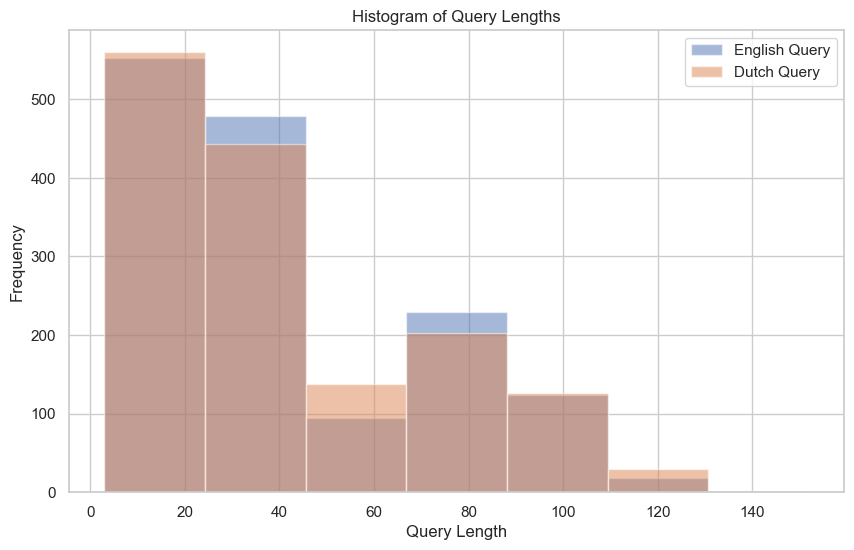

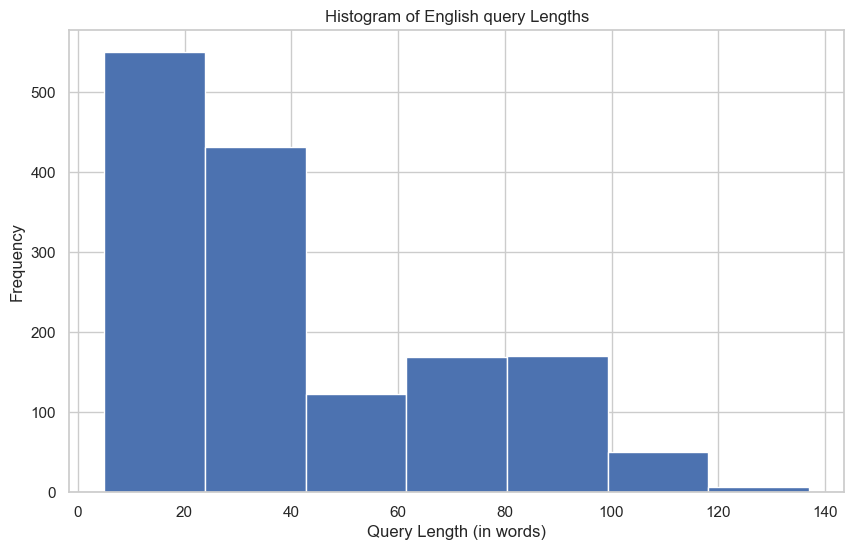

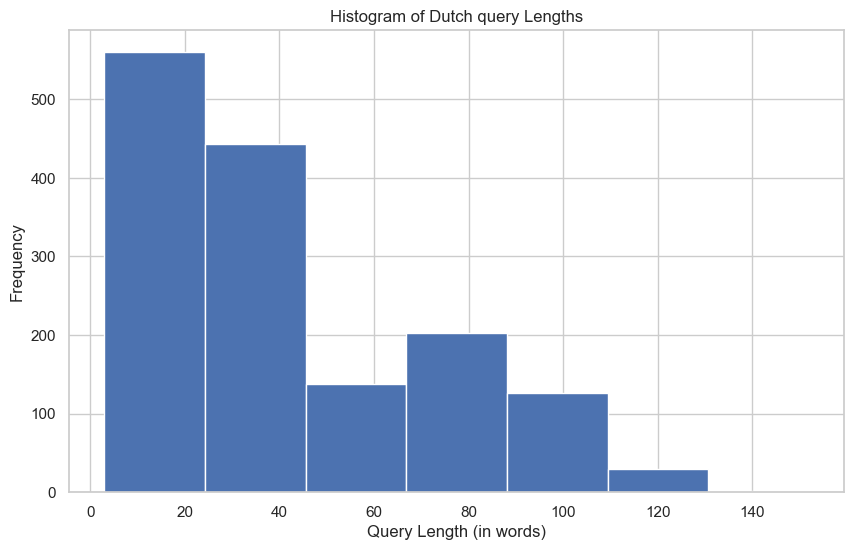

In [6]:
# visualisation of the lengths

import matplotlib.pyplot as plt

stratified_sample['English Query Length'] = stratified_sample["query_en"].str.split().str.len()  # word count
stratified_sample['Dutch Query Length'] = stratified_sample["query_nl"].str.split().str.len()

# subset dataframe for visualization
query_len_df = stratified_sample[['English Query Length', 'Dutch Query Length']]

# histogram combining languages
query_len_df.plot(kind="hist", bins=7, alpha=0.5, figsize=(10, 6))
plt.title("Histogram of Query Lengths")
plt.xlabel("Query Length")
plt.ylabel("Frequency")
plt.legend(["English Query", "Dutch Query"])
plt.savefig("hist_combined_query_lengths.pdf", bbox_inches="tight")
plt.show()

# diversity in length English queries

question_len = stratified_sample["query_en"].str.split().str.len()
question_len.hist(bins=7, figsize=(10, 6))
plt.title("Histogram of English query Lengths")
plt.xlabel("Query Length (in words)")
plt.ylabel("Frequency")
plt.savefig("hist_english_query_lengths.pdf", bbox_inches="tight")
plt.show()

# diversity in length Dutch queries

question_len = stratified_sample["query_nl"].str.split().str.len()
question_len.hist(bins=7, figsize=(10, 6))
plt.title("Histogram of Dutch query Lengths")
plt.xlabel("Query Length (in words)")
plt.ylabel("Frequency")
plt.savefig("hist_dutch_query_lengths.pdf", bbox_inches="tight")
plt.show()

In [ ]:
stratified_sample.to_csv('data/stratified_sample_with_queries.csv', index=False)